# Chapter 9: Sucker Rod Pumping Design
**Objective:** Calculate the Peak Polished Rod Load (PPRL) and generate a Dynagraph Card to size a Sucker Rod Pump system.

**Author:** Ade Anggi Naluriawan Santoso

**The System:**
1.  **Surface Unit:** Converts rotary motion (motor) to reciprocating motion (walking beam).
2.  **Rod String:** Transmits power downhole. Usually a "Tapered String" (thicker rods at top, thinner at bottom) to save weight.
3.  **Downhole Pump:** A plunger moving inside a barrel with traveling and standing valves.

**Key Design Calculations (API 11L):**
* **PPRL (Peak Polished Rod Load):** Max tension during upstroke. Used to select the "Structure Rating".
* **MPRL (Minimum Polished Rod Load):** Min tension during downstroke. Used to check for rod compression (buckling).
* **PT (Peak Torque):** Used to size the Gearbox.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Rod String Design
Deep wells require **Tapered Rod Strings**. The top rods must support their own weight plus the weight of all rods below them.

**Common API Rod Sizes:**
* **Grade D:** High strength steel.
* **Sizes:** 1.0", 7/8", 3/4", 5/8".

We will define a helper to calculate the average weight of a specific tapered design.

In [2]:
# API Rod Properties (Weight in Air lb/ft)
rod_data = {
    1.125: 3.67,  # 1-1/8"
    1.0:   2.90,  # 1"
    0.875: 2.22,  # 7/8"
    0.75:  1.63,  # 3/4"
    0.625: 1.13   # 5/8"
}

def calc_rod_weight(taper_config, total_depth):
    """
    Calculates total rod weight and average weight per ft.
    
    taper_config: List of tuples (Size_in, Percentage)
                  e.g., [(0.875, 0.40), (0.75, 0.60)]
    """
    total_weight = 0
    
    print("--- Rod String Configuration ---")
    for size, percent in taper_config:
        section_len = total_depth * percent
        w_per_ft = rod_data[size]
        section_weight = section_len * w_per_ft
        total_weight += section_weight
        print(f"Size: {size}\" | Len: {section_len:.0f} ft | Wt: {section_weight:.0f} lbs")
        
    avg_weight = total_weight / total_depth
    print(f"Total Rod Weight (Wr): {total_weight:.0f} lbs")
    return total_weight, avg_weight

## 2. Calculating Loads (Mills Method)
We use the **Mills (API)** empirical method to estimate loads.

**Upstroke (PPRL):**
$$PPRL = W_f + W_r (1 + \alpha)$$
* $W_f$: Fluid Load (Weight of fluid column on plunger).
* $W_r$: Rod Weight in air.
* $\alpha$: Acceleration Factor $= \frac{S \cdot N^2}{70500}$.

**Downstroke (MPRL):**
$$MPRL = W_r (1 - \alpha) - B_r$$
* $B_r$: Buoyancy force on rods.

In [3]:
def calc_srp_loads(pump_depth, fluid_level, plunger_diam, taper_config, stroke_len, spm, fluid_sg=1.0):
    """
    Calculates PPRL, MPRL, and Hydraulic Horsepower.
    
    Parameters:
    pump_depth   : Setting depth of pump (ft)
    fluid_level  : Dynamic fluid level (ft from surface) - determines net lift
    plunger_diam : Plunger diameter (inches)
    taper_config : Rod string definition
    stroke_len   : Surface stroke length (inches)
    spm          : Strokes Per Minute
    """
    # 1. Calculate Rod Weight (Wr)
    Wr, _ = calc_rod_weight(taper_config, pump_depth)
    
    # 2. Calculate Fluid Load (Wf)
    # Area of plunger * (Depth * Gradient)
    # Gradient of water ~ 0.433 psi/ft * SG
    grad = 0.433 * fluid_sg
    plunger_area = np.pi * (plunger_diam/2)**2
    
    # Net lift is technically fluid level depth, but pump acts on full column pressure diff
    # Simpler Mills assumption: Lift full column
    Wf = plunger_area * (pump_depth * grad)
    
    # 3. Acceleration Factor (Alpha)
    # alpha = S * N^2 / 70500 (S in inches)
    alpha = stroke_len * (spm**2) / 70500
    
    # 4. Peak Polished Rod Load (PPRL)
    PPRL = Wf + Wr * (1 + alpha)
    
    # 5. Minimum Polished Rod Load (MPRL)
    # Buoyancy of rods (approx 0.128 * Wr for steel in water)
    buoyancy_factor = 0.128 * fluid_sg
    MPRL = Wr * (1 - alpha - buoyancy_factor)
    
    # 6. Hydraulic Horsepower (HHP) - Power required to lift fluid
    # q (bpd) = 0.1484 * D^2 * S * N
    q_theor = 0.1484 * (plunger_diam**2) * stroke_len * spm
    HHP = 7.36e-6 * q_theor * fluid_sg * fluid_level
    
    return {
        "PPRL": PPRL,
        "MPRL": MPRL,
        "Wf": Wf,
        "Wr": Wr,
        "Q_theor": q_theor,
        "HHP": HHP
    }

# --- EXERCISE ---
# Depth: 5000 ft
# Rods: 40% of 7/8", 60% of 3/4"
# Pump: 1.5" Plunger
# Unit: 100 inch stroke, 10 SPM
inputs = {
    'pump_depth': 5000,
    'fluid_level': 4500, # Fluid is 500ft from bottom (high production)
    'plunger_diam': 1.5,
    'taper_config': [(0.875, 0.40), (0.75, 0.60)],
    'stroke_len': 100,
    'spm': 10
}

res = calc_srp_loads(**inputs)

print("-" * 30)
print(f"PPRL (Peak Load):   {res['PPRL']:.0f} lbs")
print(f"MPRL (Min Load):    {res['MPRL']:.0f} lbs")
print(f"Production Rate:    {res['Q_theor']:.1f} bpd")
print(f"Hydraulic Power:    {res['HHP']:.1f} HP")

--- Rod String Configuration ---
Size: 0.875" | Len: 2000 ft | Wt: 4440 lbs
Size: 0.75" | Len: 3000 ft | Wt: 4890 lbs
Total Rod Weight (Wr): 9330 lbs
------------------------------
PPRL (Peak Load):   14479 lbs
MPRL (Min Load):    6812 lbs
Production Rate:    333.9 bpd
Hydraulic Power:    11.1 HP


## 3. Visualizing the Dynagraph Card
The **Dynagraph Card** plots Load (Y-axis) vs. Position (X-axis). It is the "ECG" of the pumping unit.

* **Ideal Card:** A parallelogram (or rectangular shape).
* **Upstroke:** High load (lifting fluid + rods).
* **Downstroke:** Low load (rods falling).

We will generate a simplified Ideal Card.

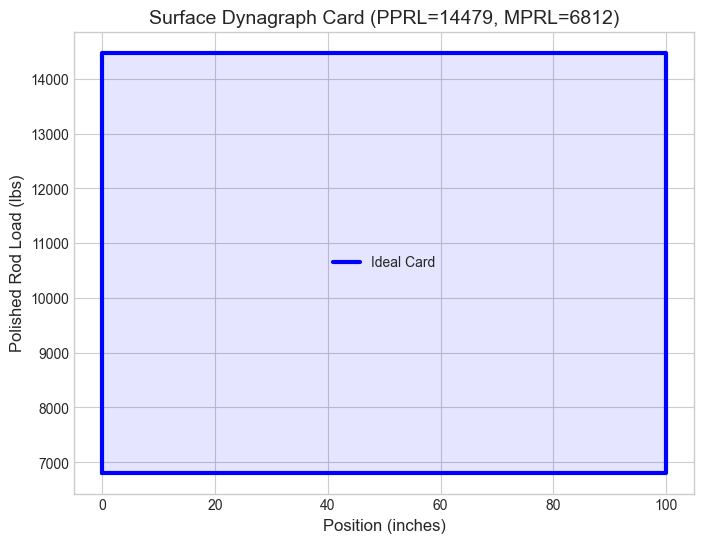

In [4]:
def plot_dynagraph(pprl, mprl, stroke_len):
    """
    Plots a simplified Ideal Dynagraph Card.
    """
    # Create the rectangular shape
    # Points: (0, MPRL) -> (S, PPRL) -> (S, PPRL) -> (0, MPRL)
    
    # Simplified mechanics:
    # 1. Start Upstroke: Load jumps to PPRL due to valve action
    # 2. End Upstroke: Load drops to MPRL
    
    # Position (inches)
    pos = [0, stroke_len, stroke_len, 0, 0]
    
    # Load (lbs) - Idealized rectangular card
    # Real cards have slant due to rod stretch
    load = [mprl, mprl, pprl, pprl, mprl] # Simplified box
    
    plt.figure(figsize=(8, 6))
    plt.plot(pos, load, color='blue', linewidth=3, label='Ideal Card')
    plt.fill(pos, load, color='blue', alpha=0.1)
    
    # Add Limits
    plt.title(f"Surface Dynagraph Card (PPRL={pprl:.0f}, MPRL={mprl:.0f})", fontsize=14)
    plt.xlabel("Position (inches)", fontsize=12)
    plt.ylabel("Polished Rod Load (lbs)", fontsize=12)
    
    plt.grid(True)
    plt.legend()
    plt.show()

plot_dynagraph(res['PPRL'], res['MPRL'], inputs['stroke_len'])

## 4. Counterbalance & Torque
To help the motor, we add counterweights to the back of the beam.
* **Ideal Counterbalance Effect (CBE):** Should range halfway between PPRL and MPRL.
    $$CBE_{ideal} \approx \frac{PPRL + MPRL}{2}$$

* **Peak Torque (PT):** The gearbox must handle the difference between the rod load and the counterbalance.
    $$PT \approx (PPRL - CBE) \cdot \frac{S}{2}$$

In [5]:
cbe_ideal = (res['PPRL'] + res['MPRL']) / 2
peak_torque = (res['PPRL'] - cbe_ideal) * (inputs['stroke_len'] / 2)

print(f"Ideal Counterbalance: {cbe_ideal:.0f} lbs")
print(f"Peak Torque on Gearbox: {peak_torque/1000:.1f} k-in-lbs")

# Unit Sizing Example:
# A "C-320-256-100" Unit means:
# C: Conventional Geometry
# 320: 320,000 in-lbs Torque Rating
# 256: 25,600 lbs Structure Rating (PPRL)
# 100: 100 inch Max Stroke

print("-" * 30)
print("Unit Selection Check:")
if res['PPRL'] < 25600:
    print("Structure (25.6k): OK")
else:
    print("Structure (25.6k): FAIL - Need larger unit")

if peak_torque < 320000:
    print("Gearbox (320k):    OK")
else:
    print("Gearbox (320k):    FAIL - Need larger gearbox")

Ideal Counterbalance: 10646 lbs
Peak Torque on Gearbox: 191.7 k-in-lbs
------------------------------
Unit Selection Check:
Structure (25.6k): OK
Gearbox (320k):    OK


## Summary
You have sized a Beam Pump!

1.  **Rod String:** Designed a tapered string to handle the depth.
2.  **Loads:** Calculated PPRL to check the unit structure rating.
3.  **Torque:** Calculated Peak Torque to check the gearbox rating.
4.  **Dynagraph:** Visualized the work cycle.